<a href="https://colab.research.google.com/github/mggg/Computational-Tools-Workshop-2026/blob/main/prefsampling_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q prefsampling

# Prefsampling tutorial: sampling cultures, Euclidean elections, and multiwinner rules

## Setup

In [ ]:
#@title Import Statements
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.manifold import MDS
from collections import Counter

from prefsampling import ordinal as pref
from prefsampling.point import ball_uniform, cube, gaussian
from prefsampling.core import concatenation
from prefsampling.core.euclidean import EuclideanSpace

plt.rcParams.update({'figure.dpi': 120})
import warnings
warnings.filterwarnings("ignore")


## Helper functions

The next set of cells contain some helper functions that we will be using in
this tutorial. Most of them are convenience functions that abstract away
some of the necessary matrix manipulations.

<font color="#cc0000"><b>Make sure to run all of the cells below, but you do not need to look into them unless you are curious.</b></font>

Here is the list of important functions defined in the below cells that we
will use later:

- `sample_euclidean(num_voters, num_candidates, num_dimensions, voters_sampler, candidates_sampler, voter_args, candidate_args)`: This first samples voter positions and candidate positions in a Euclidean space, then converts those positions into ranked ballots using the Euclidean model from ``prefsampling``.
- `borda_multiwinner(votes, m, k)`: Candidates are ranked by their total Borda scores across all voters, and the top ``k`` candidates are selected
- `greedy_cc(votes, m, k)`:  This uses Borda score and repeatedly adds the candidate that gives the largest increase in total voter satisfaction score, where each voter's satisfaction is the best score among selected candidates.
- `greedy_harmonic_borda(votes, m, k)`: This sequentially adds the candidate that maximizes the increase in the Harmonic Borda objective. For each voter, selected candidates are ordered by that voter's preference, and utilities are weighted by the reciprocal of position within the selected set.
- `plot_vote_map(votes, title, radius, coloring_func)`: Plots a 2D map of votes using an MDS embedding.
- `plot_election_2D(voters_pos, candidates_pos, votes, title)`: Plot voter and candidate locations in 2D.
- `kendall_tau_distance(v1,v2)`: Computes the Kendall-$\tau$ distance between two rankings of candidates.

In [ ]:
#@title Voting Rule Helper Functions
def ranks_from_votes(votes, m):
    """Convert ranked ballots into a rank matrix.

    Each row corresponds to one vote, and each column corresponds to one
    candidate. The value at position (i, c) is the rank assigned to
    candidate ``c`` by voter ``i``, where 0 means most preferred.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices from most preferred to least preferred.
        m: Total number of candidates.

    Returns:
        A NumPy array of shape (n, m) containing candidate ranks for each
        voter.
    """
    n = len(votes)
    # Create an empty nxm matrix
    ranks = np.empty((n, m), dtype=int)
    for i, vote in enumerate(votes):
        for r, c in enumerate(vote):
            ranks[i, c] = r
    return ranks


def borda_scores_matrix(votes, m):
    """Compute Borda ranks and per-voter Borda scores.

    Under Borda scoring, a candidate ranked first receives ``m - 1``
    points, second receives ``m - 2``, and so on down to 0.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices.
        m: Total number of candidates.

    Returns:
        A tuple ``(ranks, scores)`` where:
            - ``ranks`` is the rank matrix of shape (n, m)
            - ``scores`` is the Borda score matrix of shape (n, m)
    """
    ranks = ranks_from_votes(votes, m)
    # Some fancy vector math. If ranks is [0,1,2,3,4] and m = 5
    # then (m-1) - ranks = [4,3,2,1,0]
    scores = (m - 1) - ranks
    return ranks, scores


def borda_winner(votes, m):
    """Compute the single-winner Borda winner.

    This sums each candidate's Borda score across all voters and returns
    the candidate with the highest total score.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices.
        m: Total number of candidates.

    Returns:
        A tuple ``(winner, totals)`` where:
            - ``winner`` is the index of the winning candidate
            - ``totals`` is a NumPy array of total Borda scores by candidate
    """
    _, scores = borda_scores_matrix(votes, m)

    # sum(axis=0) sums the matrix down the column
    totals = scores.sum(axis=0)
    # np.argmax gets the location (index) of the largest value in the
    # totals vector
    winner_index = int(np.argmax(totals))
    return winner_index, totals


def borda_multiwinner(votes, m, k):
    """Compute the top-k candidates by total Borda score.

    Candidates are ranked by their total Borda scores across all voters,
    and the top ``k`` candidates are selected.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices.
        m: Total number of candidates.
        k: Number of winners to select.

    Returns:
        A tuple ``(winners, totals)`` where:
            - ``winners`` is a list of the top-k candidate indices
            - ``totals`` is a NumPy array of total Borda scores by candidate
    """
    _, scores = borda_scores_matrix(votes, m)
    totals = scores.sum(axis=0)
    # np.argsort determines the index order that would sort an array
    # so np.argsort([30,20,40,10]) returns [3,1,0,2]
    ordered_totals = np.argsort(-totals)
    # slice off the top k winner indices and turn it into a list
    winner_indices = list(ordered_totals[:k])
    return winner_indices, totals


def greedy_cc(votes, m, k):
    """Approximate Chamberlin-Courant winners using a greedy algorithm.

    This uses Borda score and repeatedly adds the candidate that
    gives the largest increase in total voter satisfaction score, where each
    voter's satisfaction is the best score among selected candidates.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices.
        m: Total number of candidates.
        k: Number of winners to select.

    Returns:
        A list of selected candidate indices.
    """
    # scores[v, c] = Borda score that voter v gives to candidate c
    _, scores = borda_scores_matrix(votes, m)

    # This will store the candidates we choose for the committee.
    selected_candidates = []

    # current_best_scores[v] = the highest score that a voter has assigned
    # to a candidate that has been selected so far
    num_voters = scores.shape[0]
    current_best_scores = np.zeros(num_voters, dtype=float)

    # We choose one candidate at a time until we have k winners.
    for _ in range(k):
        best_candidate = None
        best_gain = -1

        # Try adding each candidate that is not already selected.
        for candidate in range(m):
            if candidate in selected_candidates:
                continue

            # If we added this candidate, each voter would compare:
            #   - their current favorite candidate's score
            #   - this candidate's score
            # and keep the better one.
            current_candidate_scores = scores[:, candidate]
            new_best_scores = np.maximum(current_best_scores, current_candidate_scores)

            # The "gain" is how much total satisfaction increases.
            old_total = current_best_scores.sum()
            new_total = new_best_scores.sum()
            gain = new_total - old_total

            # Keep track of the candidate with the largest gain.
            if gain > best_gain:
                best_gain = gain
                best_candidate = candidate

        # Add the best candidate found this round.
        selected_candidates.append(best_candidate)

        # Update each voter's current favorite candidate's score
        current_best_scores = np.maximum(
            current_best_scores,
            scores[:, best_candidate]
        )

    return selected_candidates

def greedy_harmonic_borda(votes, m, k):
    """Approximate Harmonic Borda winners using a greedy algorithm.

    This sequentially adds the candidate that maximizes the increase in
    the Harmonic Borda objective. For each voter, selected candidates are
    ordered by that voter's preference, and utilities are weighted by the
    reciprocal of position within the selected set.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices.
        m: Total number of candidates.
        k: Number of winners to select.

    Returns:
        A list of selected candidate indices.
    """
    # ranks[v, c] = position of candidate c in voter v's ranking
    # scores[v, c] = Borda score that voter v gives candidate c
    ranks, scores = borda_scores_matrix(votes, m)

    num_voters = len(votes)
    selected_candidates = []

    def hb_utility_for_voter(selected_set, voter_index):
        """Compute one voter's Harmonic Borda utility for a selected set.

        The selected candidates are first sorted according to this voter's
        preference. Then the most preferred selected candidate gets full
        weight, the second gets weight 1/2, the third gets weight 1/3, etc.

        Args:
            selected_set: List of selected candidate indices.
            voter_index: Index of the voter.

        Returns:
            The Harmonic Borda utility for the given voter.
        """
        # No selected candidates means no utility.
        if not selected_set:
            return 0.0

        # Reorder the selected candidates from best to worst according
        # to this particular voter.
        ordered_candidates = sorted(
            selected_set,
            key=lambda candidate: ranks[voter_index, candidate]
        )

        utility = 0.0

        # Add up weighted Borda scores:
        # first candidate chosen by this voter gets weight 1,
        # second gets weight 1/2,
        # third gets weight 1/3, etc.
        for position, candidate in enumerate(ordered_candidates, start=1):
            utility += scores[voter_index, candidate] / position

        return utility

    # current_utilities[v] = current Harmonic Borda utility for voter v
    current_utilities = np.zeros(num_voters, dtype=float)

    # Select candidates one at a time.
    for _ in range(k):
        best_candidate = None
        best_gain = -1

        # Try each candidate not already selected.
        for candidate in range(m):
            if candidate in selected_candidates:
                continue

            # Pretend we add this candidate.
            trial_set = selected_candidates + [candidate]

            # Compute the total increase in utility across all voters.
            total_gain = 0.0
            for voter_index in range(num_voters):
                new_utility = hb_utility_for_voter(trial_set, voter_index)
                old_utility = current_utilities[voter_index]
                total_gain += new_utility - old_utility

            # Keep the candidate with the best improvement.
            if total_gain > best_gain:
                best_gain = total_gain
                best_candidate = candidate

        # Add the best candidate found this round.
        selected_candidates.append(best_candidate)

        # Recompute each voter's utility after the selection.
        for voter_index in range(num_voters):
            current_utilities[voter_index] = hb_utility_for_voter(
                selected_candidates,
                voter_index
            )

    return selected_candidates

In [ ]:
#@title Metric Helper Functions

def kendall_tau_distance(v1, v2):
    """Compute the Kendall tau distance between two rankings.

    Args:
        v1: A ranking represented as an ordered iterable of candidate
            identifiers.
        v2: A second ranking over the same candidates.

    Returns:
        The number of pairwise inversions between the two rankings.
    """
    # Build a lookup table for the positions in v1.
    # Example:
    #   v1 = [2, 0, 1]
    #   pos = {2: 0, 0: 1, 1: 2}
    position_in_v1 = {candidate: i for i, candidate in enumerate(v1)}

    # Rewrite v2 in terms of positions from v1.
    # If v2 = [0, 2, 1], then p = [1, 0, 2].
    # Counting inversions in p tells us how many pairwise disagreements
    # there are between v1 and v2.
    p = [position_in_v1[candidate] for candidate in v2]

    inversions = 0
    for i in range(len(p)):
        for j in range(i + 1, len(p)):
            # If an earlier element is larger than a later one,
            # that pair is inverted.
            if p[i] > p[j]:
                inversions += 1

    return inversions

def embed_votes_mds(votes, seed=7):
    """Embed rankings into 2D using MDS on Kendall tau distances.

    This computes the pairwise Kendall tau distance between all votes,
    stores those distances in a distance matrix, and then applies
    multidimensional scaling (MDS) to place the votes in 2D.

    Args:
        votes: Iterable of rankings, where each ranking is an ordered
            iterable of candidate identifiers.
        seed: Random seed passed to the MDS routine for reproducibility.

    Returns:
        A NumPy array of shape (n, 2) giving 2D coordinates for each vote.
    """
    num_voters = len(votes)

    # D[i, j] will store the distance between vote i and vote j.
    distance_matrix = np.zeros((num_voters, num_voters), dtype=float)

    # Fill in only the upper triangle, then mirror it to the lower triangle
    # (distances are symmetric, so this is fine.)
    for i in range(num_voters):
        for j in range(i + 1, num_voters):
            distance = kendall_tau_distance(votes[i], votes[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    # Set up the MDS class and tell it we will use a precomputed distance matrix.
    mds = MDS(
        n_components=2,
        dissimilarity='precomputed',
        random_state=seed,
    )

    # Return the 2D coordinates for each vote.
    return mds.fit_transform(distance_matrix)

In [ ]:
#@title Plotting Functions
def plot_vote_map(votes, title='Vote map (MDS)', radius=None, coloring_func=None):
    """Plot a 2D map of votes using an MDS embedding.

    Duplicate votes are grouped together so that identical ballots are
    plotted once, with point size scaled by how often that vote appears.

    Args:
        votes: Iterable of ballots, where each ballot is an ordering of
            candidate indices.
        title: Title for the plot.
        radius: Optional radius for fixing the axis limits around the
            center of the embedded points.
        coloring_func: Optional function that takes a vote and returns a
            color value for that point.

    Returns:
        A tuple ``(fig, ax)`` containing the Matplotlib figure and axes.
    """
    # Count duplicates and keep a single representative vote for plotting.
    counts = Counter(tuple(v) for v in votes)
    unique_votes = [list(v) for v in counts.keys()]

    # Compute 2D coordinates for the unique votes.
    coords = embed_votes_mds(unique_votes)

    # Either color all points blue, or use the provided coloring function.
    if coloring_func is None:
        colors = 'blue'
    else:
        colors = [coloring_func(v) for v in unique_votes]

    # Compute the center of the embedded point cloud.
    avg_x = np.mean(coords[:, 0])
    avg_y = np.mean(coords[:, 1])

    # Scale point sizes by identical vote counts so duplicates stand out.
    base_size = 20
    sizes = [base_size * counts[tuple(v)] for v in unique_votes]

    fig, ax = plt.subplots(figsize=(3, 3))

    if radius is not None:
        # Compute integer axis bounds explicitly to satisfy static analyzers.
        xmin = int(avg_x - radius)
        xmax = int(avg_x + radius)
        ymin = int(avg_y - radius)
        ymax = int(avg_y + radius)
        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    else:
        # Add a bit of white margin when radius isn't specified.
        ax.margins(0.25)

    # Draw the vote points with transparency so overlapping points are easier to see.
    ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)
    ax.axis('off')
    ax.set_title(title)
    return fig, ax


def plot_election_2d(voters_pos, candidates_pos, votes=None, title=''):
    """Plot voter and candidate locations in 2D.

    Voters are shown as faint gray points and candidates are shown as
    labeled black X markers.

    Args:
        voters_pos: NumPy array of voter coordinates with shape (n, 2).
        candidates_pos: NumPy array of candidate coordinates with shape
            (m, 2).
        votes: Optional collection of ballots. Currently only used to
            determine whether vote data was provided.
        title: Title for the plot.

    Returns:
        None. This function draws directly using Matplotlib.
    """
    if votes is None:
        colors = 'gray'
    else:
        colors = [v[0] for v in votes]

    plt.figure(figsize=(4, 4))

    # Plot voters as light background points.
    plt.scatter(voters_pos[:, 0], voters_pos[:, 1], c='tab:gray', cmap='tab20', s=25, alpha=0.1, label='voters')

    plt.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='blue', s=40, marker='o', alpha=0.6, label='candidates')

    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()


def plot_candidates_2d(candidates_pos, title='', ax=None, annotate=True, label=None):
    """Plot candidate locations in 2D.

    Args:
        candidates_pos: NumPy array of candidate coordinates with shape
            (m, 2).
        title: Optional title for the axes.
        ax: Optional Matplotlib axes to draw on. If not provided, the
            current axes are used.
        annotate: Whether to label each candidate with its index.
        label: Optional legend label for the candidate points.

    Returns:
        The Matplotlib axes containing the plot.
    """
    # Use the current axes if none were provided.
    if ax is None:
        ax = plt.gca()

    # Draw candidates as black X markers.
    ax.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='black', s=120, marker='X', label=label or 'candidates')

    # Optionally place index labels on top of each candidate point.
    if annotate:
        for i, (x, y) in enumerate(candidates_pos):
            ax.text(x, y, str(i), fontsize=9, ha='center', va='center', color='white')

    if title:
        ax.set_title(title)

    ax.legend(loc='upper right')
    return ax

# Another plotting function to help us with viz in the next code cell
def plot_winners(candidate_sets, winners, ax=None, title=''):
    """Plot winner sets across multiple elections.

    Args:
        candidate_sets: List of candidate position arrays, where each array
            has shape (m, 2).
        winners: List where winners[i] contains the selected candidate
            indices for candidate_sets[i].
        ax: Optional Matplotlib axes to draw on.
        title: Optional plot title.

    Returns:
        A tuple (fig, ax) containing the figure and axes.
    """
    # Passing an axes object allows for multiple plots to appear on
    # the same figure.

    # If no axes are provided, create a new figure and axes.
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    else:
        # If axes already exist, use the figure they belong to.
        fig = ax.figure

    for i in range(len(candidate_sets)):
        candidates_pos = candidate_sets[i]
        selected_indices = winners[i]

        # First draw every candidate in this election as a faint blue point.
        # These serve as the background, showing the full candidate layout.
        ax.scatter(
            x=candidates_pos[:, 0],
            y=candidates_pos[:, 1],
            c='blue',
            s=20,
            marker='o',
            alpha=0.05,
        )

        # Convert the winner indices to a NumPy integer array so they can be
        # used directly to pick out the winning rows from candidates_pos.
        sel = np.array(selected_indices, dtype=int)

        # Draw the selected winners again, on top of the background points,
        # so they stand out as larger red markers.
        ax.scatter(
            x=candidates_pos[sel, 0],
            y=candidates_pos[sel, 1],
            c='red',
            s=35,
            marker='o',
            alpha=0.33,
        )

    ax.axis('off') # Remove the box around the figure region
    if title:
        ax.set_title(title)
    fig.tight_layout() # Remove any extra padding around the figure
    return fig, ax

# A plotting function to help us with viz in the next code cell
def plot_committee(candidates_pos, committee, title):
    """Plot candidate locations and highlight a selected committee.

    All candidates are shown as faint blue points, and the selected
    committee members are overlaid as larger red points.

    Args:
        candidates_pos: NumPy array of candidate coordinates with shape
            (m, 2).
        committee: Iterable of selected candidate indices.
        title: Title for the plot.

    Returns:
        None. This function draws directly using Matplotlib.
    """
    # Create a new figure for the committee plot.
    plt.figure(figsize=(3, 3))

    # Plot all candidates as light blue background points.
    plt.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='blue', s=40, marker='o', alpha=0.2)

    # Convert the selected committee indices into a NumPy array so we can
    # use them to index directly into candidates_pos.
    sel = np.array(committee, dtype=int)

    # Plot the selected committee members on top in red.
    plt.scatter(candidates_pos[sel, 0], candidates_pos[sel, 1], c='red', s=80, marker='o', alpha=0.6)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()


def plot_one_kemeny(votes, best_order):
    """
    Plot unique votes and the Kemeny ranking in a 2D MDS embedding.

    The function first deduplicates the input votes, then computes the
    Kendall tau distance from each unique vote to the given Kemeny ranking.
    These distances are used to set the transparency of the plotted vote
    points: votes closer to the Kemeny ranking appear more opaque.

    Both the unique votes and the Kemeny ranking are embedded together into
    the same two-dimensional space using multidimensional scaling (MDS), so
    their relative positions are directly comparable. Votes are shown as blue
    circles, and the Kemeny ranking is highlighted as a large blue star.

    Parameters
    ----------
    votes : list[list]
        A list of rankings (votes), where each vote is an ordered list of
        candidates/items.
    best_order : list
        The Kemeny ranking to highlight in the plot.

    Returns
    -------
    None
        Displays the plot on the current matplotlib axes.

    Notes
    -----
    - Duplicate votes are removed before plotting.
    - Vote opacity reflects proximity to the Kemeny ranking under Kendall tau
      distance.
    - The plot axes are hidden for a cleaner visualization.
    """

    # Unique votes for plotting
    unique_votes = [list(v) for v in Counter(tuple(v) for v in votes).keys()]

    # Convert Kemeny orders to name lists
    kemeny_rankings = [best_order]

    # Distance of each vote to the Kemeny ranking
    distances = []
    for v in unique_votes:
        d1 = kendall_tau_distance(v, kemeny_rankings[0])
        distances.append(d1)

    dmin = min(distances) if distances else 0
    dmax = max(distances) if distances else 0

    def alpha_for(d):
        if dmax == dmin:
            return 0.6
        return 0.2 + 0.8 * (dmax - d) / (dmax - dmin)

    colors = [mcolors.to_rgba('blue', alpha_for(distances[i])) for i in range(len(unique_votes))]

    # Embed votes + Kemeny ranking together so they are in the same MDS space
    all_votes = unique_votes + kemeny_rankings
    coords = embed_votes_mds(all_votes)

    vote_coords = coords[:len(unique_votes)]
    kemeny_coords = coords[len(unique_votes):]

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(vote_coords[:, 0], vote_coords[:, 1], c=colors, s=30, label='votes')

    ax.scatter(kemeny_coords[:, 0], kemeny_coords[:, 1],
               c='blue', s=260, marker='*', label='Kemeny',
               edgecolors='black', linewidths=1.5)

    ax.axis('off')


def plot_two_kemeny(votes, best_pair):
    """
    Plot unique votes and two Kemeny rankings in a 2D MDS embedding.

    The function deduplicates the input votes, then compares each unique vote
    to the two provided Kemeny rankings using Kendall tau distance. Each vote
    is assigned to the closer of the two rankings (breaking ties in favor of
    the first ranking), and its transparency is determined by that minimum
    distance: votes closer to one of the Kemeny rankings appear more opaque.

    The unique votes and both Kemeny rankings are embedded together into the
    same two-dimensional space using multidimensional scaling (MDS), so their
    relative positions are directly comparable. Votes closer to the first
    Kemeny ranking are shown as red circles, votes closer to the second are
    shown as blue circles, and the two Kemeny rankings are highlighted as
    large star markers.

    Parameters
    ----------
    votes : list[list]
        A list of rankings (votes), where each vote is an ordered list of
        candidates/items.
    best_pair : tuple[list, list]
        A pair of Kemeny rankings to highlight in the plot.

    Returns
    -------
    None
        Displays the plot on the current matplotlib axes.

    Raises
    ------
    ValueError
        If no 2-Kemeny pair is provided.

    Notes
    -----
    - Duplicate votes are removed before plotting.
    - Each vote is colored according to the closer Kemeny ranking.
    - Vote opacity reflects proximity to the nearest Kemeny ranking under
      Kendall tau distance.
    - The plot axes are hidden for a cleaner visualization.
    """

    if not best_pairs:
        raise ValueError('No 2-Kemeny pairs provided.')

    # Unique votes for plotting
    unique_votes = [list(v) for v in Counter(tuple(v) for v in votes).keys()]

    # Use the first optimal pair (if multiple)
    kemeny_rankings = [list(best_pair[0]), list(best_pair[1])]

    # Assign each vote to the closest Kemeny ranking
    closer_to_first = []
    distances = []
    for v in unique_votes:
        d1 = kendall_tau_distance(v, kemeny_rankings[0])
        d2 = kendall_tau_distance(v, kemeny_rankings[1])
        closer_to_first.append(d1 <= d2)
        distances.append(min(d1, d2))

    # Alpha proportional to distance (normalized)
    dmin = min(distances) if distances else 0
    dmax = max(distances) if distances else 0

    def alpha_for(d):
        if dmax == dmin:
            return 0.6
        return 1 -  0.8 * (d - dmin) / (dmax - dmin)

    # Embed votes + Kemeny rankings together so they are in the same MDS space
    all_votes = unique_votes + kemeny_rankings
    coords = embed_votes_mds(all_votes)

    vote_coords = coords[:len(unique_votes)]
    kemeny_coords = coords[len(unique_votes):]

    idx_first = [i for i, is_first in enumerate(closer_to_first) if is_first]
    idx_second = [i for i, is_first in enumerate(closer_to_first) if not is_first]

    from matplotlib import colors as mcolors
    colors_first = [mcolors.to_rgba('red', alpha_for(distances[i])) for i in idx_first]
    colors_second = [mcolors.to_rgba('blue', alpha_for(distances[i])) for i in idx_second]

    fig, ax = plt.subplots(figsize=(3, 3))
    if idx_first:
        ax.scatter(
            vote_coords[idx_first, 0],
            vote_coords[idx_first, 1],
            c=colors_first,
            s=30,
            label='closer to Kemeny-1'
        )
    if idx_second:
        ax.scatter(
            vote_coords[idx_second, 0],
            vote_coords[idx_second, 1],
            c=colors_second,
            s=30,
            label='closer to Kemeny-2'
        )

    ax.scatter(kemeny_coords[0, 0], kemeny_coords[0, 1],
               c='red', s=260, marker='*', label='Kemeny-1',
               edgecolors='black', linewidths=1.5)
    ax.scatter(kemeny_coords[1, 0], kemeny_coords[1, 1],
               c='blue', s=260, marker='*', label='Kemeny-2',
               edgecolors='black', linewidths=1.5)

    ax.axis('off')

In [ ]:
#@title Sampling Functions
def sample_euclidean(num_voters, num_candidates, num_dimensions, voters_sampler, candidates_sampler, **kwargs):
    """Sample an Euclidean election from voter and candidate point sets.

    This first samples voter positions and candidate positions in a
    Euclidean space, then converts those positions into ranked ballots
    using a Euclidean preference model.

    Args:
        num_voters: Number of voters to generate.
        num_candidates: Number of candidates to generate.
        num_dimensions: Dimension of the Euclidean space.
        voters_sampler: Function used to generate voter positions.
        candidates_sampler: Function used to generate candidate positions.
        **kwargs: Optional keyword arguments. Expected keys include
            ``voters_args`` and ``candidates_args``, each containing a
            dictionary of sampler-specific arguments.

    Returns:
        A tuple ``(voters_pos, cand_pos, votes)`` where:
            - ``voters_pos`` is the array of voter coordinates
            - ``cand_pos`` is the array of candidate coordinates
            - ``votes`` is the generated collection of ranked ballots
    """
    # Sample voter locations in the Euclidean space.
    voters_pos = voters_sampler(num_voters, num_dimensions, **kwargs.get('voters_args', {}))

    # Sample candidate locations in the same Euclidean space.
    cand_pos = candidates_sampler(num_candidates, num_dimensions, **kwargs.get('candidates_args', {}))

    # Convert geometric positions into preference rankings.
    votes = pref.euclidean(
        num_voters,
        num_candidates,
        num_dimensions,
        voters_pos,
        cand_pos,
    )

    return voters_pos, cand_pos, votes


# 2D: voters uniform in cube, candidates from a 2-Gaussian mixture
def gaussian_mixture(num_points, num_dimensions, centers, sigmas, weights=None, seed=None):
    """Sample points from a Gaussian mixture model.

    Each component is a Gaussian distribution centered at one of the given
    centers, with the corresponding standard deviation specified by ``sigmas``.
    The total number of sampled points is divided among components according to
    the given mixture weights.

    Args:
        num_points: Total number of points to sample.
        num_dimensions: Dimension of the space.
        centers: Sequence of component centers.
        sigmas: Sequence of standard deviations (or per-dimension spreads)
            for each component.
        weights: Optional mixture weights for the components. If not
            provided, all components are weighted equally.
        seed: Optional random seed for reproducibility.

    Returns:
        A NumPy array of sampled points with shape
        ``(num_points, num_dimensions)`` when at least one point is
        generated, or an empty array with shape ``(0, num_dimensions)``
        if no component receives any samples.
    """
    # Convert centers to a NumPy array for easier numeric handling.
    centers = np.array(centers, dtype=float)

    if len(centers) != len(sigmas):
        raise ValueError('centers and sigmas must have the same length')
    if weights is None:
        weights = np.ones(len(centers), dtype=float) / len(centers)

    # Normalize weights so they sum to 1.
    weights = np.array(weights, dtype=float)
    weights = weights / weights.sum()

    # Use a local random number generator for reproducibility.
    rng = np.random.default_rng(seed)

    # Randomly decide how many points to draw from each mixture component.
    counts = rng.multinomial(num_points, weights)
    parts = []

    for count, center, sigma in zip(counts, centers, sigmas):
        if count == 0:
            continue
        parts.append(
            gaussian(
                count,
                num_dimensions,
                center_point=center,
                sigmas=sigma,
                seed=int(rng.integers(0, 1_000_000_000)),
            )
        )

    # If every component got zero points, return an empty array.
    if not parts:
        candidates_pos = np.empty((0, num_dimensions))
    else:
        # Stack all component samples into one array.
        candidates_pos = np.vstack(parts)

    return candidates_pos



In [ ]:
#@title Kemeny Functions

from collections import Counter
from itertools import permutations, combinations
from math import comb

def one_kemeny(votes, return_scores=False):
    """Find a ranking with small total Kendall tau distance to the votes.

    For speed, this implementation uses a heuristic: instead of searching over
    all possible rankings, it only considers rankings that already appear in
    the input profile. This makes the procedure much faster, but it may miss
    the true Kemeny optimum.

    Args:
        votes: Iterable of rankings, where each ranking is an ordered
            iterable of candidate identifiers.
        return_scores: If True, also return the best objective value.

    Returns:
        If return_scores is False:
            A list of rankings from the input votes that minimize the total
            Kendall tau distance among the rankings considered by the heuristic.

        If return_scores is True:
            A tuple ``(best_candidate_order, best_total)`` where
            ``best_candidate_order`` is a minimizing ranking found by the
            heuristic, and ``best_total`` is its total Kendall tau distance
            to the votes.
    """
    best_total = None
    best_candidate_order = []

    for possible_candidate_ranking in votes:
        total = 0

        # Compute the total Kendall tau distance from this candidate
        # ranking to every voter's ranking in the profile.
        for voter_ranking in votes:
            total += kendall_tau_distance(
                voter_ranking,
                possible_candidate_ranking,
            )

        # If this is the first ranking checked, or it improves on the
        # current best total, replace the stored best result.
        if best_total is None or total < best_total:
            best_total = total
            best_candidate_order = list(possible_candidate_ranking)

    if return_scores:
        return best_candidate_order, best_total

    # Return the best rankings.
    return best_candidate_order


def two_kemeny(votes, return_scores=False):
    """Find a good pair of rankings under a two-center Kemeny objective.

    For speed, this implementation uses a heuristic: instead of searching over
    all possible pairs of rankings, it only considers pairs formed by rankings
    that already appear in the input profile. For each vote, it computes the
    Kendall tau distance to both rankings in the pair and uses the smaller of
    the two distances. The best pair is the one minimizing the total of these
    minimum distances across all votes. This is much faster than a full search,
    but it may miss the true optimum.

    Args:
        votes: Iterable of rankings, where each ranking is an ordered
            iterable of candidate identifiers.
        return_scores: If True, also return the best objective value.

    Returns:
        If return_scores is False:
            A pair of rankings (as two lists) minimizing the total two-center
            Kendall tau distance among the pairs considered by the heuristic.

        If return_scores is True:
            A tuple ``(best_pair, best_total)`` where ``best_pair`` is the
            minimizing pair found by the heuristic and ``best_total`` is its
            total score.
    """
    # This function only searches over rankings that already appear
    # in the input votes.
    all_orders = votes

    # Precompute distances from each voter ranking to each candidate
    # consensus ranking once, so we do not repeat the same work for
    # every pair.
    #
    # After this:
    #   order_distances[i][k] = distance from votes[k] to all_orders[i]
    order_distances = []
    for candidate_ranking in all_orders:
        distances_to_this_ranking = [
            kendall_tau_distance(voter_ranking, candidate_ranking)
            for voter_ranking in votes
        ]
        order_distances.append(distances_to_this_ranking)

    # Track the best pair found so far and its total score.
    best_total = None
    best_pair = []

    # Store scores for every pair, in case you want to inspect them later.
    pair_totals = {}

    # Check every unordered pair of candidate rankings.
    for i, j in combinations(range(len(all_orders)), 2):
        total = 0

        # Distances from every voter to the i-th and j-th candidate rankings.
        distance_to_first = order_distances[i]
        distance_to_second = order_distances[j]

        # For each voter, assign them to whichever of the two rankings
        # is closer, then add that distance to the total.
        for voter_index in range(len(votes)):
            total += min(
                distance_to_first[voter_index],
                distance_to_second[voter_index],
            )

        # Save this pair's score using tuples so it can be used as a dict key.
        pair_key = (tuple(all_orders[i]), tuple(all_orders[j]))
        pair_totals[pair_key] = total

        # Store the pair in list form for the final return value.
        pair = (list(all_orders[i]), list(all_orders[j]))

        # If this pair is the best so far, update the current best.
        if best_total is None or total < best_total:
            best_total = total
            best_pair = pair

    if return_scores:
        return best_pair, best_total

    return best_pair


## Classic statistical cultures (IC, Urn, Mallows)
Statistical cultures are probability models for generating synthetic elections. They help us study how voting rules behave under different types of preference structure. In this section, we look at four classic examples: IC, Urn, Mallows, and Single-Peaked, each capturing a different pattern of voter preferences. <br> <br>
IC - Impartial Culture (https://comsoc-community.github.io/prefsampling/reference/ordinal/impartial.html) <br>
Urn - Pólya-Eggenberger urn model (https://comsoc-community.github.io/prefsampling/reference/ordinal/urn.html) <br>
Mallows - Mallows model (https://comsoc-community.github.io/prefsampling/reference/ordinal/mallows.html) <br>
SP - Single Peaked model (https://comsoc-community.github.io/prefsampling/reference/ordinal/singlepeaked.html)


In [ ]:
n, m = 100, 8   # number of voters, number of candidates

In [ ]:
votes_ic = pref.impartial(
    num_voters=n,
    num_candidates=m
)
plot_vote_map(
    votes=votes_ic,
    title='IC vote map'
)

In [ ]:
alpha = 0.25   # <- TRY CHANGING THIS
votes_urn = pref.urn(
    num_voters=n,
    num_candidates=m,
    alpha=alpha
)
plot_vote_map(
    votes=votes_urn,
    title=f'Urn model (alpha={alpha})'
)

In [ ]:
votes_mallows = pref.norm_mallows(
    num_voters=n,
    num_candidates=m,
    norm_phi=0.1    # the norm_phi parameter controls the concentration of the Mallows model
)
plot_vote_map(
    votes=votes_mallows,
    title='Norm-Mallows (n-phi=0.1)',
    radius=16
)

votes_mallows = pref.norm_mallows(
    num_voters=n,
    num_candidates=m,
    norm_phi=0.25
)
plot_vote_map(
    votes=votes_mallows,
    title='Norm-Mallows (n-phi=0.25)',
    radius=16
)

votes_mallows = pref.norm_mallows(
    num_voters=n,
    num_candidates=m,
    norm_phi=0.5
)
plot_vote_map(
    votes=votes_mallows,
    title='Norm-Mallows (n-phi=0.5)',
    radius=16
)

## Structured domains: Single-Peaked elections

Try changing the random seed to see how it affects the structure of the generated election.

(<Figure size 360x360 with 1 Axes>,
 <Axes: title={'center': 'Single-Peaked (Conitzer)'}>)

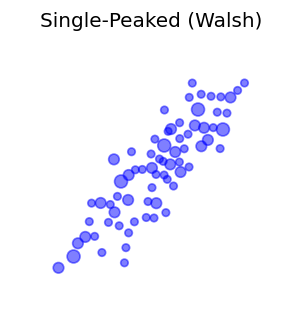

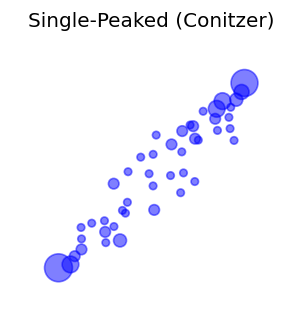

In [70]:
n, m = 100, 8

votes_sp_w = pref.single_peaked_walsh(
    num_voters=n,
    num_candidates=m,
    seed=11           # <- TRY CHANGING THIS
)
votes_sp_c = pref.single_peaked_conitzer(
    num_voters=n,
    num_candidates=m,
    seed=11           # <- TRY CHANGING THIS
)

plot_vote_map(
    votes=votes_sp_w,
    title='Single-Peaked (Walsh)'
)
plot_vote_map(
    votes=votes_sp_c,
    title='Single-Peaked (Conitzer)'
)

Try changing the coloring function to highlight different features of the votes.
For example, you can color all points the same way, assign an RGB tuple, or use
information from the vote itself, such as the top-ranked or bottom-ranked candidate.
Some ideas: <br>
    'orange' <br>
    (0.25, 0.5, 0) <br>
    vote[0] <br>
    vote[-1]

(<Figure size 360x360 with 1 Axes>, <Axes: title={'center': 'Single-Peaked'}>)

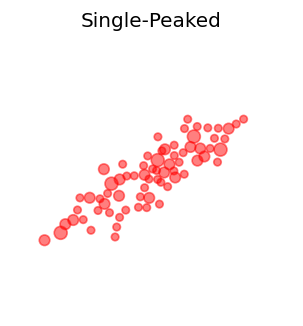

In [72]:
n, m = 100, 8

def my_coloring_func(vote):
    return 'red'         # <- TRY CHANGING THIS

votes_sp_w = pref.single_peaked_walsh(
    num_voters=n,
    num_candidates=m,
    seed=11
)

plot_vote_map(
    votes=votes_sp_w,
    title='Single-Peaked',
    radius=16,
    coloring_func=my_coloring_func
)


## Mixtures of Mallows models

A mixture model combines several preference distributions into one election. This is a simple way to represent different voter groups with different underlying preferences. Here, we mix two Mallows models with different central rankings.


In [ ]:
n1, n2 = 50, 50
m = 8

votes = concatenation(
    num_voters_per_sampler=[
        n1, # size of the first group of voters
        n2  # size of the second group of voters
    ],
    num_candidates=m,
    samplers=[
        pref.norm_mallows, # <- TRY CHANGING THIS
        pref.norm_mallows
    ],
    sampler_parameters=[
        {'norm_phi': 0.33, 'central_vote': range(m)},  # arguments passed to the first sampler in the `samplers` list
        {'norm_phi': 0.33, 'central_vote': range(m-1,-1,-1)},  # arguments passed to the second sampler in the `samplers` list
    ]
)

plot_vote_map(
    votes=votes,
    title='Mixture of Mallows models'
)


## 2D-Euclidean elections
In a 2D-Euclidean election, both voters and candidates are represented as points in a two-dimensional space. You can think of this space as describing two underlying political or ideological dimensions, although the axes do not need to have a fixed interpretation. Each voter has an ideal point, and each candidate also has a position in the same space. <br> <br>
A voter’s preference ranking is then determined by distance: candidates closer to the voter’s ideal point are ranked higher, while candidates farther away are ranked lower. In other words, voters prefer candidates whose positions are most similar to their own. Once all voter and candidate points are sampled, we can convert these distances into ordinal preferences by sorting candidates from nearest to farthest for each voter.

In the code below, try the widths of the voter and candidate distributions to see how it changes the election. For example, you can make voters more concentrated in a small area while candidates are spread out, or vice versa.

In [ ]:
# 2D: voters in a ball, candidates in a wider cube
n, m = 100, 25

v2, c2, votes2 = sample_euclidean(
    num_voters=n,
    num_candidates=m,
    num_dimensions=2,
    voters_sampler=cube,
    candidates_sampler=cube,
    voters_args={'widths': 1.0},     # <- TRY CHANGING THIS
    candidates_args={'widths': 1.0}  # <- TRY CHANGING THIS
)

plot_election_2d(
    voters_pos=v2,
    candidates_pos=c2,
    votes=votes2,
    title='2D: Cube'
)

## Voting rules: Borda, GreedyCC, Greedy Harmonic Borda
In this section, we compare the behavior of three voting rules on a Euclidean election.

In [ ]:
m = c2.shape[0]
k = 10  # committee_size

borda_w, _ = borda_multiwinner(votes2, m, k)
cc_committee = greedy_cc(votes2, m, k)
hb_committee = greedy_harmonic_borda(votes2, m, k)

print('Borda winner:', borda_w)
print('GreedyCC committee:', cc_committee)
print('Greedy Harmonic Borda committee:', hb_committee)

plot_committee(
    candidates_pos=c2,
    committee=borda_w,
    title='Borda: individual excellence'
)
plot_committee(
    candidates_pos=c2,
    committee=cc_committee,
    title='GreedyCC: coverage/diversity'
)
plot_committee(
    candidates_pos=c2,
    committee=hb_committee,
    title='GreedyHB: proportionality'
)


In [ ]:
# These lists store the data for all simulated election.
# - candidate_sets[i] holds the candidate coordinates for election i
# - cc_winners[i], hb_winners[i], and borda_winners[i] hold the
#   corresponding winner sets for that same election
candidate_sets = []
cc_winners = []
hb_winners = []
borda_winners = []

Try running the code below multiple times to see the patterns of different voting rules.

In [ ]:

# Parameters for the candidate distribution:
# candidates are sampled from a mixture of two Gaussian clusters.
centers = [[-0.25, -0.25], [0.25, 0.25]]
sigmas = [0.12, 0.12]
weights = [0.7, 0.3]

# Generate one Euclidean election:
# - 100 voters
# - 100 candidates
# - 2D positions
# - voters sampled uniformly from a square/cube
# - candidates sampled from the Gaussian mixture above
v_new, c_new, votes_new = sample_euclidean(
    num_voters=100,
    num_candidates=100,
    num_dimensions=2,
    voters_sampler=cube,                  # <- TRY CHANGING THIS!
    candidates_sampler=gaussian_mixture,  # <- TRY CHANGING THIS!
    voters_args={'widths': 1.0}, # passed to the "cube" sampler
    candidates_args={            # passed to the "gaussian_mixture" sampler
        'centers': centers,
        'sigmas': sigmas,
        'weights': weights,
    },
)

# Number of candidates in this election.
m_new = c_new.shape[0]

# Choose the committee size.
committee_size = 10

# Compute winner sets using three different multiwinner rules.
cc_committee_new = greedy_cc(votes_new, m_new, committee_size)
hb_committee_new = greedy_harmonic_borda(votes_new, m_new, committee_size)
borda_committee_new, _ = borda_multiwinner(votes_new, m_new, committee_size)

# Store this election's candidate positions and the corresponding winners
# so they can be plotted later.
candidate_sets.append(c_new)
cc_winners.append(cc_committee_new)
hb_winners.append(hb_committee_new)
borda_winners.append(borda_committee_new)

# Create a row of three plots, one for each voting rule.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Plot the winners chosen by each rule on top of the same candidate layout.
plot_winners(candidate_sets, cc_winners, ax=axes[0], title='CC winners')
plot_winners(candidate_sets, hb_winners, ax=axes[1], title='HB winners')
plot_winners(candidate_sets, borda_winners, ax=axes[2], title='Borda winners')

# Adjust spacing so the three plots fit neatly.
plt.tight_layout()

# Part two: Polarization

## Kemeny ranking

In this section, we compute a **1-Kemeny ranking**: a single ranking that maximizes agreement among the voters (equivalently minimizes the total Kendall-tau distance).

In [ ]:
n, m = 100, 10

candidates = range(m)
votes = pref.impartial(
    num_voters=n,
    num_candidates=m
)

best_order = one_kemeny(votes)
plot_one_kemeny(votes, best_order)

In [ ]:
n, m = 50, 10

candidates = range(num_candidates)
votes = pref.impartial(
    num_voters=n,
    num_candidates=m
)

best_pairs = two_kemeny(votes)
plot_two_kemeny(votes, best_pairs)

## 2-Kemeny ranking
In this section, we compute a **2-Kemeny ranking**. <br>

Note that, for larger sizes these may be slower. Start small and scale up if time allows.


In [ ]:
n1, n2 = 50, 50      # <- TRY CHANGING THIS!
m = 10
votes = concatenation(
    num_voters_per_sampler=[
        n1, # size of the first group of voters
        n2  # size of the second group of voters
    ],
    num_candidates=m,
    samplers=[
        pref.norm_mallows,
        pref.norm_mallows
    ],
    sampler_parameters=[
        {'norm_phi': 0.67, 'central_vote': range(m)},          # <- TRY CHANGING THIS!
        {'norm_phi': 0.5, 'central_vote': range(m-1, -1, -1)}  # <- TRY CHANGING THIS!
    ]
)

best_pairs, two_kemeny_score = two_kemeny(votes, return_scores=True)
plot_two_kemeny(votes, best_pairs)

Try playing with the sizes of the groups and see how the polarization changes. For example, you can make one group much larger than the other.

In [ ]:
n1, n2 = 50, 50 # <- TRY CHANGING THIS!
m = 10
votes = concatenation(
    num_voters_per_sampler=[
        n1, # size of the first group of voters
        n2  # size of the second group of voters
    ],
    num_candidates=m,
    samplers=[pref.norm_mallows, pref.norm_mallows],  # list of samplers
    sampler_parameters=[
        {'norm_phi': 0.1, 'central_vote': range(m)}, # <- TRY CHANGING THIS!
        {'norm_phi': 0.1, 'central_vote': range(m-1, -1, -1)}
    ]  # parameters of the samplers
)
n = n1 + n2

best_order, one_kemeny_score = one_kemeny(votes, return_scores=True)
# plot_one_kemeny(votes, best_order)

best_pair, two_kemeny_score = two_kemeny(votes, return_scores=True)
plot_two_kemeny(votes, best_pair)

def polarization(k1, k2):
    return 2 * (k1 - k2) / (n * comb(m, 2))

P = polarization(one_kemeny_score, two_kemeny_score)
print(f"Polarization: {round(P,4)}")
